In [2]:
cd ..

/home/osselinp/semisupervised


In [19]:
import numpy as np
from module.quadrature import Quadrature, QuadratureExplorationBis
from botorch.models import SingleTaskGP
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from module.utils import nearestPD
from module.plot_script import plot_GP_fit_ax, posterior_quad

In [25]:
def plot_synthesis(model, quad, objective, bounds, standardize=False, mean_Y=None, std_Y=None):
    b = np.arange(-float(bounds), float(bounds), 0.1)
    d = np.arange(0, 9, 0.1)[1:]
    B, D = np.meshgrid(b, d)
    n, m = b.shape[0], d.shape[0]
    res = torch.stack((torch.tensor(B.flatten()), torch.tensor(D.flatten())), axis = 1).numpy()
    result = []
    for el in tqdm(res):
        post = posterior_quad(model, el[0], el[1])
        result.append(post)
    mean = torch.tensor(result).numpy()[:,0].reshape(m,n)
    
    #t_linspace = torch.linspace(0., quad.t_max, quad.budget, dtype=quad.train_X.dtype)
    #result_wolfe = []
    #for t in t_linspace:
    #    result_wolfe.append(quad.compute_p_wolfe(t))
    #wolfe_tensor = torch.tensor(result_wolfe)

    ## Compute gradients at multiple places
    b_grad = np.arange(-float(bounds), float(bounds), 1)
    d_grad = np.arange(0, 3, 0.5)[1:]
    B_grad, D_grad = np.meshgrid(b_grad, d_grad)
    #n_grad, m_grad = b_grad.shape[0], d_grad.shape[0]
    res_grad = torch.stack((torch.tensor(B_grad.flatten()), torch.tensor(D_grad.flatten())), axis = 1).numpy()
    result_grad, max_length = [], 0
    for el in tqdm(res_grad):
        mean_distrib_grad, var_distrib_grad = torch.tensor([el[0]], dtype=torch.float64, device=model.train_inputs[0].device), torch.diag(torch.tensor([el[1]], dtype=torch.float64, device=model.train_inputs[0].device))
        quad_distrib_grad = MultivariateNormal(mean_distrib_grad, var_distrib_grad)
        quad_grad = Quadrature(model=model,
                distribution=quad_distrib_grad)
        quad_grad.quadrature()
        quad_grad.gradient_direction()
        mu_grad, epsilon_grad = float(quad_grad.d_mu.detach().clone()), float(quad_grad.d_epsilon.detach().clone())
        max_length = max(max_length, np.sqrt(mu_grad**2 + epsilon_grad**2))
        result_grad.append([mu_grad, epsilon_grad])
        
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    plot_GP_fit_ax(axs[0,0], model, quad.distribution, model.train_inputs[0], model.train_targets, objective, standardize=standardize, lb=-float(bounds), up=float(bounds), mean_Y=mean_Y, std_Y=std_Y)

    contour1 = axs[0,1].contourf(B, D, mean)
    # Gradient
    arrow_factor = 5
    for i, el in tqdm(enumerate(res_grad)):
        axs[0, 1].arrow(el[0], el[1], arrow_factor*result_grad[i][0]/max_length, arrow_factor*result_grad[i][1]/max_length, width = 0.1)
    axs[0,1].set_xlabel(r'$\mu$')
    axs[0,1].set_ylabel(r'$\sigma^{2}$')
    axs[0,1].set_title(r"Predictive mean of $g(\theta)$")


    #contour4 = axs[1,1].contourf(B, D, mean)
    #mu2 = float(quad.distribution.loc + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_mu)
    #Epsilon2 = float(nearestPD(quad.distribution.covariance_matrix + float(t_linspace[np.argmax(wolfe_tensor)])*quad.d_epsilon))

    #axs[1,0].plot(t_linspace.numpy(), wolfe_tensor.numpy())

    #axs[1,1].scatter([float(quad.distribution.loc)], [float(quad.distribution.covariance_matrix)])
    #axs[1,1].scatter([mu2], [Epsilon2])
    #axs[1,1].arrow(float(quad.distribution.loc), float(quad.distribution.covariance_matrix), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_mu), float(t_linspace[np.argmax(wolfe_tensor)]*quad.d_epsilon), width = 0.1)
    fig.colorbar(contour1, ax=axs[0,0])
    fig.colorbar(contour1, ax=axs[0,1])
    #fig.colorbar(contour4, ax=axs[1,1])
    fig.show()
    return fig, axs

In [26]:
objective = lambda x: 5*torch.exp(-2*(x - 1)**2) + 5*torch.exp(-2*(x + 1)**2)
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([0.]), torch.diag(torch.tensor([2.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 50
bounds = 2
lb, up= -10., 10.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
train_Y = (objective(train_X)).sum(dim=1, keepdim=True)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y = None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

100%|██████████| 50/50 [00:00<00:00, 144.13it/s]
50it [00:00, 752.37it/s]


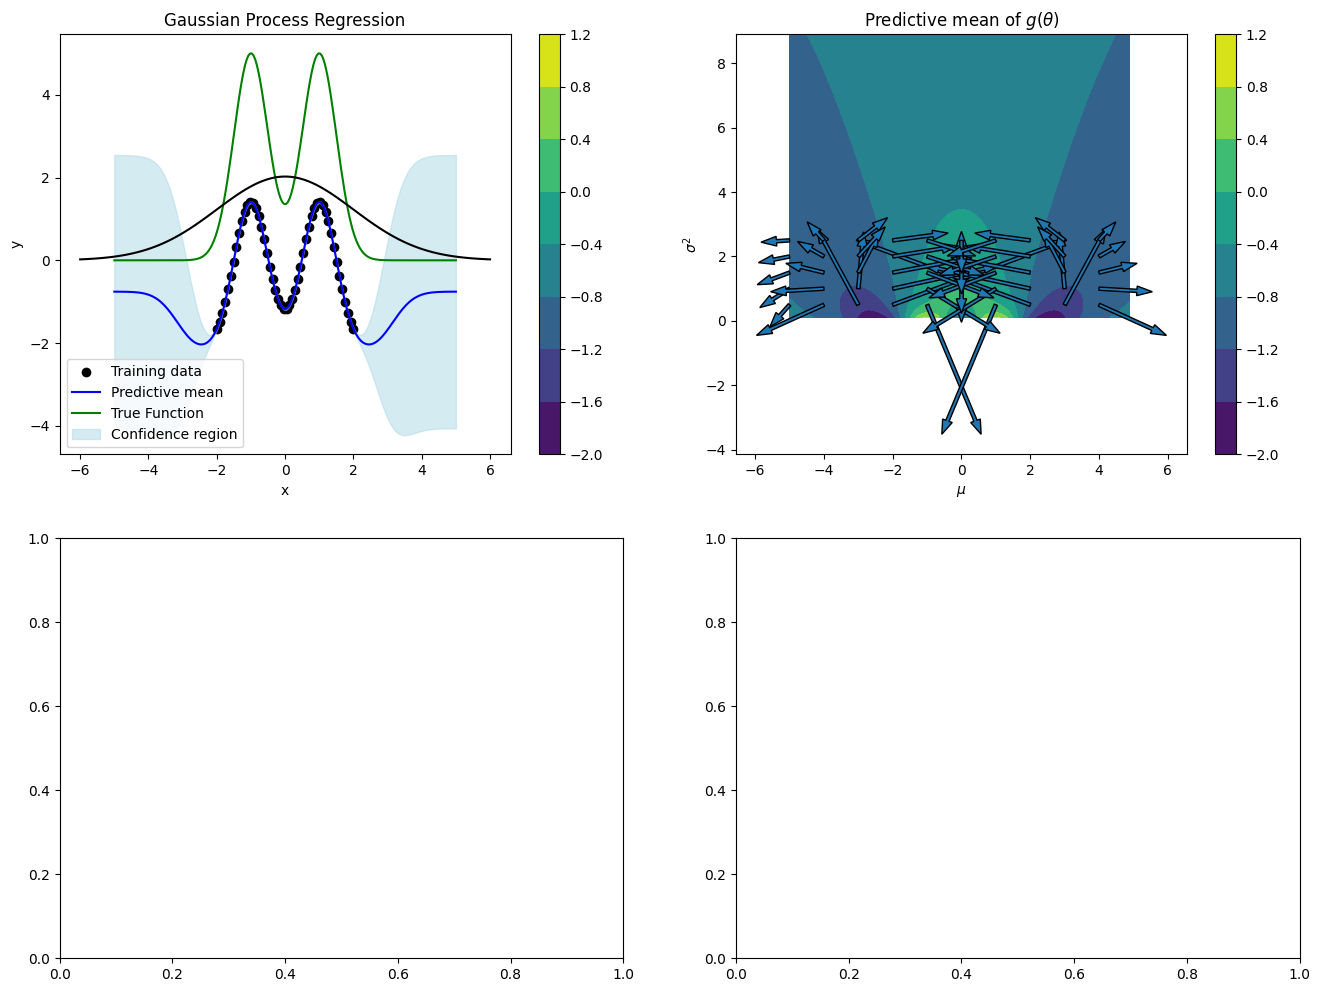

In [27]:
quad = Quadrature(model=model,
            distribution=quad_distrib)
quad.quadrature()
quad.gradient_direction()

fig, axs = plot_synthesis(model, quad, objective, 5., standardize=False, mean_Y=None, std_Y=None)